# MODELING

Welcome to the Modelling Notebook of the Kiva Capstone Project! This imbalanced classification problem is done with  Logistic Regression and Decision Trees. The Score we want to maximise is Precision. Since the use case scenario is promting future 'expired' loans on the front page of the website, we want to make sure to predict only these loans, and minimise those that are predicted 'expired' too but would have been actually funded either way - or False Positives. Minimising False Positives means increasing precision.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, average_precision_score

In [2]:
loans = pd.read_csv('/Users/nicolas/Downloads/loans_data_modelling.csv')

In [3]:
loans.drop(columns=['Unnamed: 0'],inplace=True)

In [4]:
sample = loans.sample(frac=0.3)

In [5]:
y = sample['status']
X = sample.copy().drop('status',axis=1)

## BASIC MODELS

Let's first start with some basic models to have a baseline score we need to beat.

In [6]:
x_train,x_test, y_train, y_test = train_test_split(
    X,y, stratify=y, test_size=0.3, random_state=1)

In [7]:
rf = RandomForestClassifier(n_estimators = 300)
rf.fit(x_train, y_train)
print(rf.score(x_test, y_test))
x_predrf = rf.predict(x_test)
print(precision_score(y_test,x_predrf))

0.9570630194213591
0.8793363499245852


In [8]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(x_train, y_train)
print(logreg.score(x_test, y_test))
x_predlr = logreg.predict(x_test)
print(precision_score(y_test,x_predlr))

/Users/nicolas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9548575618861384
0.53239608801956


The random forest basic model came back with a 0.854 precision, which is quite a good score. This is the score we're going to try and beat with the next models.

## INBALANCE CLASSIFICATION METHODS

As you can see there is a severe imbalance in class labels, as the occurance of class 1 happens only 0.045% of the time. To cope with this challenge, I tried two methods : Cost Sensitive methods and Sampling Methods.

In [9]:
loans.status.value_counts(normalize=True)

0    0.954313
1    0.045687
Name: status, dtype: float64

## COST SENSITIVE METHOD

Cost Sensitive methods consist in tuning the 'class_weight' parameter which gives slightly more importance to the minority class when modelling. Grisearch instantiates many models and brings back the one with the highest precision. Tried it both with random forests and logistic regression. 

### RANDOM FOREST

In [10]:
params = {'class_weight': [{0:0.01,1:0.02},{0:0.01,1:0.03},{0:0.01,1:0.4},{0:0.01,1:0.05}]}
gs = GridSearchCV(estimator= RandomForestClassifier(n_estimators=100),
                  param_grid=params,
                  cv=5,
                  scoring='precision',
                  verbose=1)
# fit the gridsearch object on your training data
gs.fit(x_train, y_train)

# extract the grid search results
# print out the best parameters
print('Best Parameters:')
print(gs.best_params_)
# print out the best mean cross-validated score
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(x_train, y_train))
# score your model on your testing data
print('Best estimator score on the test set:')
print(gs.score(x_test, y_test))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 48.6min finished


Best Parameters:
{'class_weight': {0: 0.01, 1: 0.02}}
Best estimator mean cross validated training score:
0.8827472019286585
Best estimator score on the full training set:
0.9998958658752474
Best estimator score on the test set:
0.8753541076487252


In [11]:
params = {'class_weight': [{0:0.01,1:0.01},{0:0.01,1:0.02},{0:0.01,1:0.03}]}
gs2 = GridSearchCV(estimator= LogisticRegression(max_iter = 10000),
                  param_grid=params,
                  cv=5,
                  scoring='precision',
                  verbose=1)
# fit the gridsearch object on your training data
gs2.fit(x_train, y_train)

# extract the grid search results
# print out the best parameters
print('Best Parameters:')
print(gs2.best_params_)
# print out the best mean cross-validated score
print('Best estimator mean cross validated training score:')
print(gs2.best_score_)
print('Best estimator score on the full training set:')
print(gs2.score(x_train, y_train))
# score your model on your testing data
print('Best estimator score on the test set:')
print(gs2.score(x_test, y_test))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 245.6min finished


Best Parameters:
{'class_weight': {0: 0.01, 1: 0.01}}
Best estimator mean cross validated training score:
0.5310341622707517
Best estimator score on the full training set:
0.5438175270108043
Best estimator score on the test set:
0.5307262569832403


In [12]:
csrf = gs.best_estimator_

In [13]:
x_pred_csrf = csrf.predict(x_test)
print(precision_score(y_test,x_pred_csrf))

0.8753541076487252


In [14]:
print(accuracy_score(y_test,x_pred_csrf))

0.9572130127549887


In [15]:
scores = cross_val_score(csrf, X, y, scoring='precision', cv=5)

In [16]:
print(np.mean(scores))

0.8550967230628418


## SAMPLING METHODS

The next method we can try is using Random Sampling to sample the training set in order to train on better proportions of class label percentages.

In [17]:
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
x_train,x_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=1)
x_train,y_train = over.fit_resample(x_train,y_train)
x_train, y_train = under.fit_resample(x_train,y_train)

In [18]:
srf = RandomForestClassifier(n_estimators = 300)
srf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=300)

In [19]:
srf.score(x_test,y_test)

0.9605628638727167

In [20]:
x_pred_srf = srf.predict(x_test)
print(precision_score(y_test,x_pred_srf))

0.7453443048938935


In [21]:
slr = LogisticRegression(max_iter=10000)
slr.fit(x_train, y_train)

print(slr.score(x_test, y_test))

x_pred_slr = slr.predict(x_test)
print(precision_score(y_test,x_pred_slr))

0.877927647660104
0.23670294297976702


## CONFUSION MATRIX

Let's print out the confusion matrices of our 2 best models, the basic random forest and the cost-sensitive random forest. 

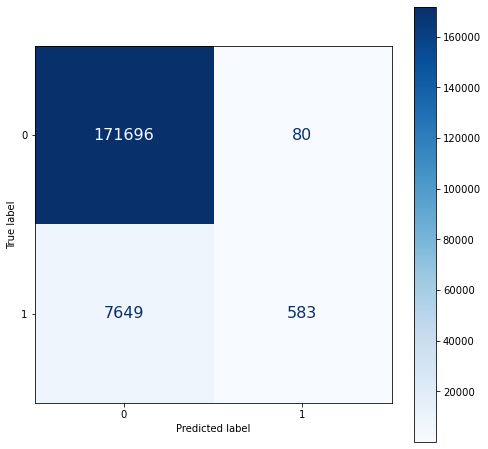

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(rf, x_test, y_test, cmap='Blues',labels=[0,1],values_format = '.0f',ax=ax)

texts = ax.texts
for text in texts:
    text.set_size(16)

plt.show()

- 77/(560+77) = 0.120. 
- 94 / (612+94) = 0.133

Hence, with our best model, 12% of loans promoted would actually be False Positives, or loans which would have been funded either way. 

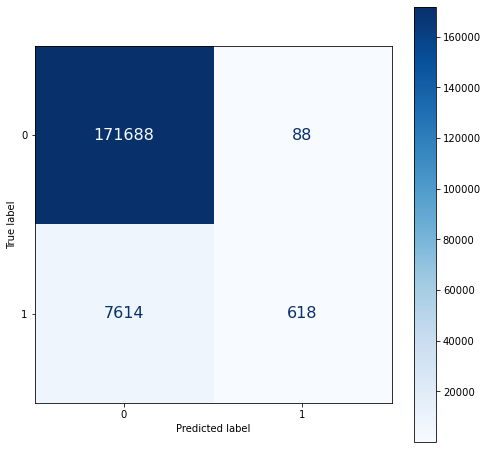

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(csrf, x_test, y_test, cmap='Blues', ax=ax)

texts = ax.texts
for text in texts:
    text.set_size(16)

plt.show()

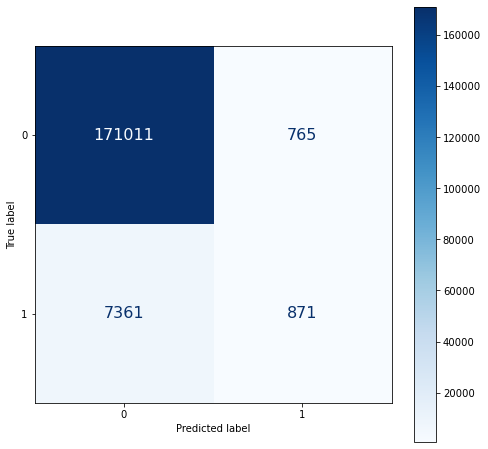

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(logreg, x_test, y_test, cmap='Blues',labels=[0,1],values_format = '.0f',ax=ax)

texts = ax.texts
for text in texts:
    text.set_size(16)

plt.show()

## INFERENCE

These are the coeeffients and feature importances of the basic logistic regression and random forests, which are also our best models.

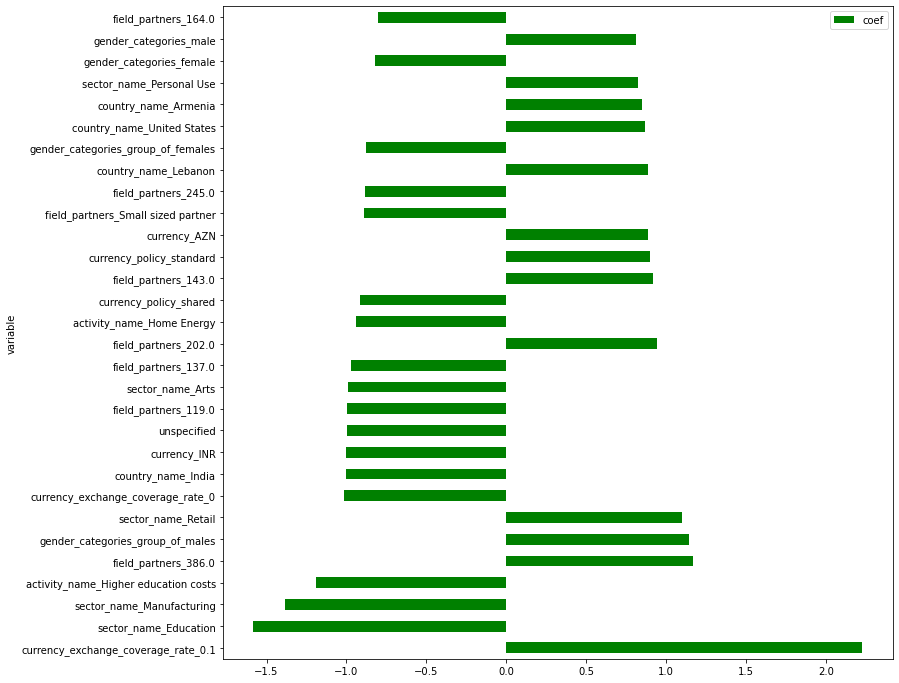

In [27]:
coefs_logreg = pd.DataFrame({
    'coef': logreg.coef_[0],
    'variable': X.columns,
    'abscoef': np.abs(logreg.coef_[0])
})
coefs_logreg.sort_values('abscoef', ascending=False, inplace=True)
coefs_logreg.head(30).plot(kind='barh', x='variable', y='coef',
                      color='g', figsize=(12, 12), label='coef')
plt.show()

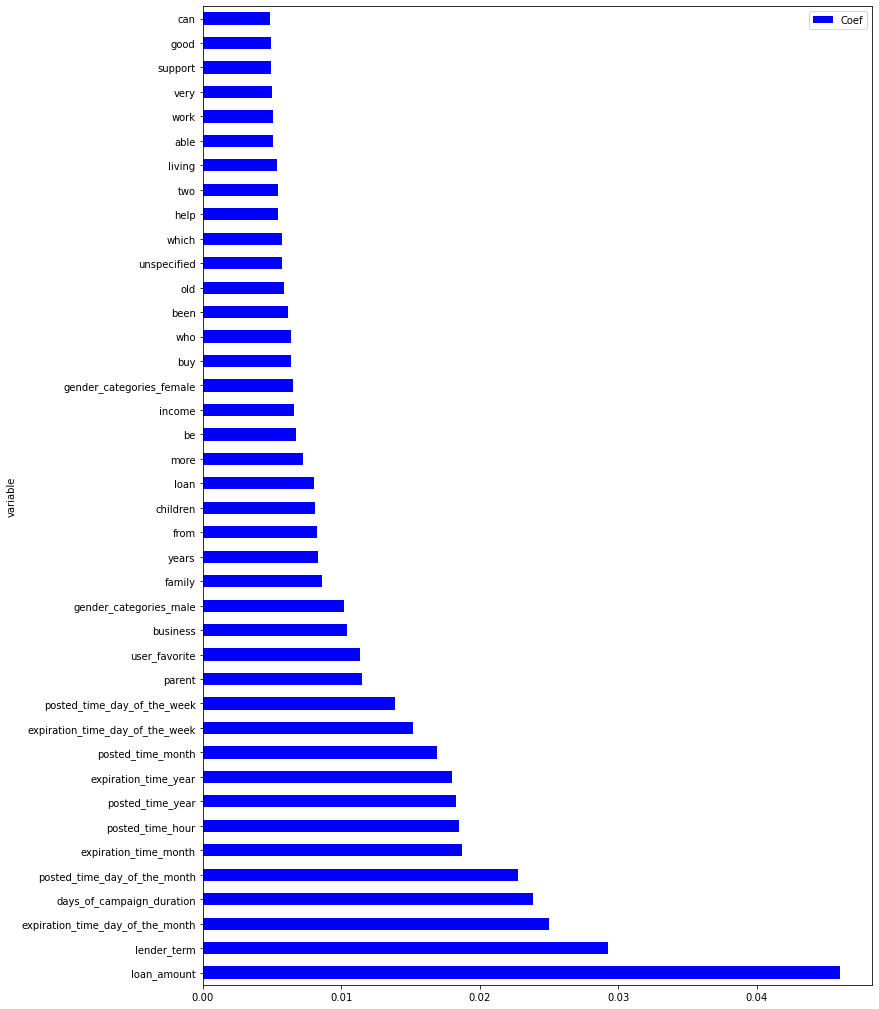

In [28]:
coefs_rf = pd.DataFrame({
    'feature_importances': rf.feature_importances_,
    'variable': X.columns})
coefs_rf.sort_values('feature_importances', ascending=False, inplace=True)
coefs_rf.head(40).plot(kind='barh', x='variable', y='feature_importances',
                      color='b', figsize=(12, 18), label='Coef')
plt.show()

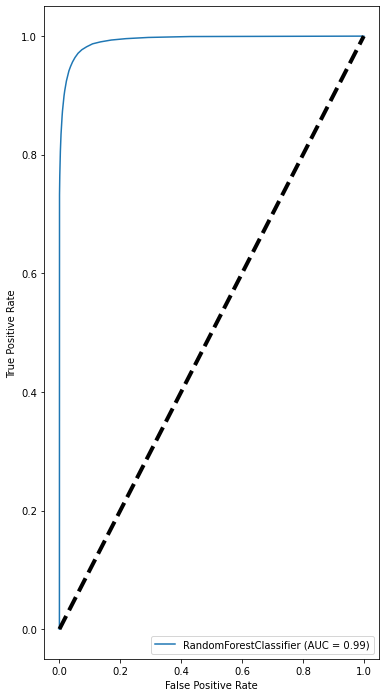

In [29]:
fig, ax = plt.subplots(figsize=(6, 12))
plot_roc_curve(csrf, X, y, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.show()

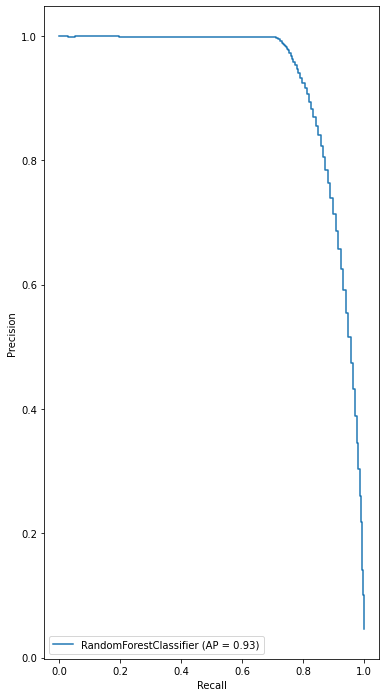

In [30]:
fig, ax = plt.subplots(figsize=(6, 12))
plot_precision_recall_curve(csrf, X, y, ax=ax)
plt.show()